## Описание задачи

Руководство компании обратило внимание на то, что сотрудники старше 35 лет болеют чаще, чем более молодые сотрудники. Кроме этого, среди мужчин количество пропусков рабочих дней в связи с больничным выше, чем среди женщин. В связи с этой ситуацией, руководство организации планирует ввести дополнительные медицинские осмотры среди групп риска. 
Вам необходимо проверить следующие гипотезы:
1. Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин.
2. Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег.

Решение необходимо предоставить: 
1. В виде jupyter notebook (с аккуратно оформленным кодом, графиками и описанной логикой решения). 
2. В виде дашборда на Streamlit с простым функционалом: 
    - должна быть возможность загрузить csv, в формате аналогично файлу «Статистика»
    - должна быть возможность задать параметры age и work_days
    - указан результат проверки гипотез
    - указана логика получения результата (должны быть отрисованы графики распределений, указаны критерии проверки (стат. тесты, статистики, уровень значимости т.п.) 


## Импорты и функции

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [3]:
def data_spread(df, column):
    
    '''Объясняет распределение в непрерывных признаках'''
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    
    df.boxplot(column=column, ax=ax[0])
    ax[0].set_title(f'Диаграмма размаха на столбце {column}', fontsize=(8))
    ax[0].grid(True)

    ax[1].hist(df[column], bins=200)
    ax[1].set_title(f'Гистограмма на столбце {column}', fontsize=(8))
    ax[1].grid(True)

    fig.suptitle(f'Разброс данных столбца {column}', fontsize=(12))

    plt.show()
    print('    ', '-'*104)

## Выгрузка данных

In [4]:
# Изучим информацию о поступившем DS
df = pd.read_csv('stats.csv', index_col=0)

display(df.head(3))
display(df.info())
display(df.describe())

,Количество больничных дней,Возраст,Пол
0,5,39,Ж
1,4,54,М
2,4,26,М


<class 'pandas.core.frame.DataFrame'>
Int64Index: 237 entries, 0 to 236
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Количество больничных дней  237 non-null    int64 
 1   Возраст                     237 non-null    int64 
 2   Пол                         237 non-null    object
dtypes: int64(2), object(1)
memory usage: 7.4+ KB


None

,Количество больничных дней,Возраст
count,237.000000,237.000000
mean,3.257384,40.181435
std,1.807821,6.875157
min,0.000000,23.000000
25%,2.000000,36.000000
50%,3.000000,41.000000
75%,4.000000,45.000000
max,8.000000,60.000000


In [5]:
# Проверим уникальные значения категориального столбца
df['Пол'].unique()

array(['Ж', 'М'], dtype=object)

Категориальные данные отображены корректно

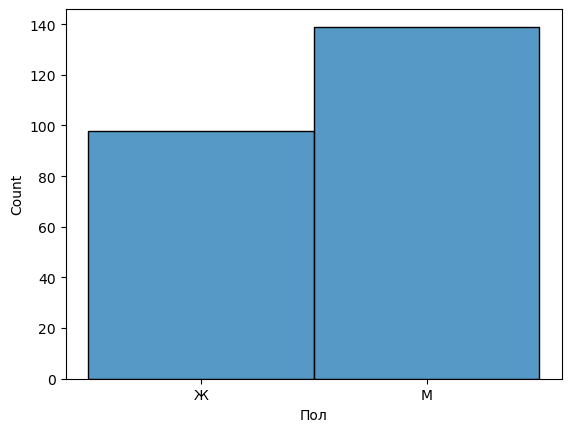

In [6]:
# Посмотрим как распределены значения М и Ж
sns.histplot(df['Пол']);

In [7]:
men = df.loc[df['Пол'] == 'М', 'Пол'].count() / df.shape[0]
women = df.loc[df['Пол'] == 'Ж', 'Пол'].count() / df.shape[0]
print('Количество Мужчин в выборке = ', '{:.2%}'.format(men))
print('Количество Женщин в выборке = ', '{:.2%}'.format(women))
print('Разница', '{:.2%}'.format(men - women))

Количество Мужчин в выборке =  58.65%
Количество Женщин в выборке =  41.35%
Разница 17.30%


Мы имеем небольшое отклонение по количеству мужчин в отношении женщин, которые берут отпуск по болезни в компании. Разница выражена несущественно и составляет 17%. Такой показатель не должен сильно повлиять на статистику, но всё же нужно будет учесть при гипотезах.

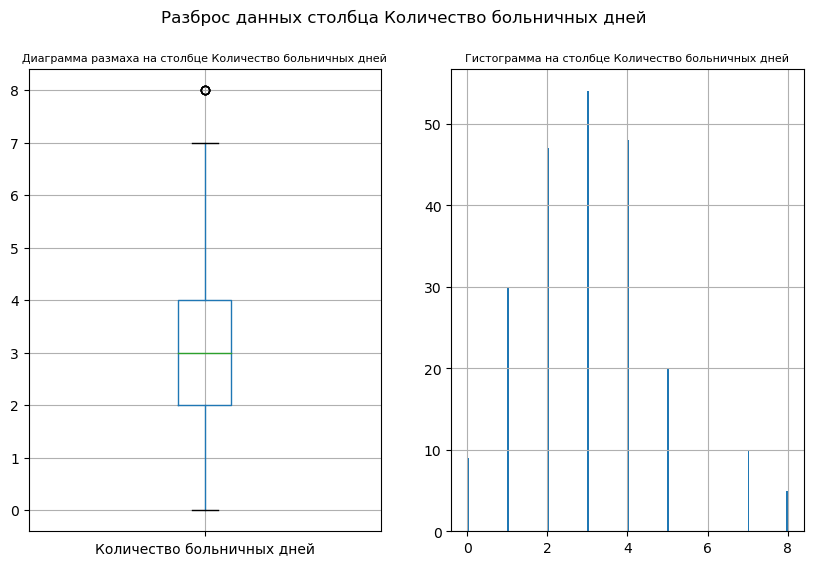

     --------------------------------------------------------------------------------------------------------


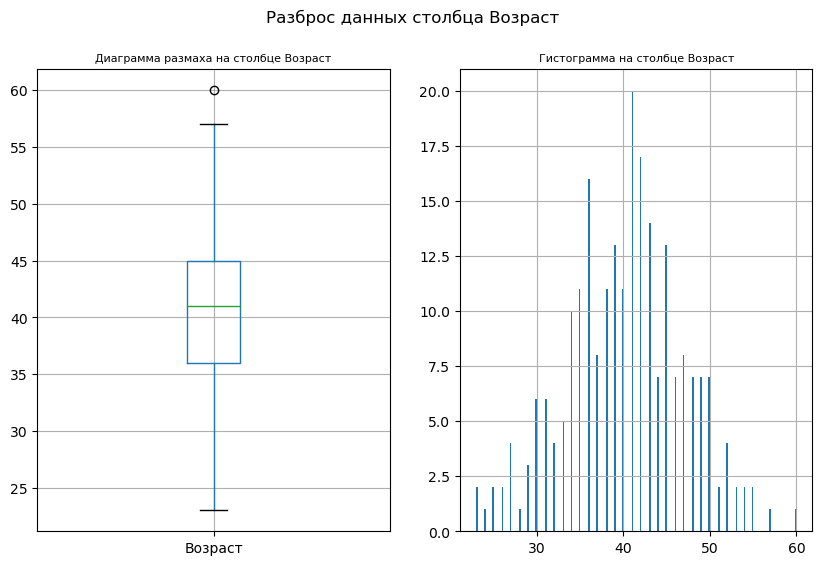

     --------------------------------------------------------------------------------------------------------


In [8]:
# Посмотрим как распределены дискретные столбцы
for column in ['Количество больничных дней', 'Возраст']:
    data_spread(df, column)

1. Количество больничных дней - пиковое значение в данной выборке достигает 3 больничных дней, максимальное возможное - 8 (выброс), а также минимальное - 0, что является, как мне кажется, некорректным в отношении больничных дней, тк $X_i > 0$ - устроним при предобработке данных. В среднем люди берут "отгул" на срок от 2 до 4 рабочих дней.
2. Возраст - признак имеет нормальное распределение с параметром m равным 40 годам и дисперсией 47 (std = 6.87). Тогда в среднем мы имеем людей в возрасте от 36 до 45 лет, судя по boxplot. Также присутствует аномалия равная 60 годам, но это корректный возраст работы.

In [9]:
# Посмотрим количество значений 0 в признаке "Количество больничных дней"
df.loc[df['Количество больничных дней'] == 0, 'Количество больничных дней'].count()

9

## Предобработка данных

In [10]:
df = df.loc[df['Количество больничных дней'] != 0]
sorted(df['Количество больничных дней'].unique())

[1, 2, 3, 4, 5, 6, 7, 8]

In [17]:
# Кластеризуем возраст на две группы
df.loc[df['Возраст'] > 35, 'Возрастная группа'] = 'Старше 35 лет'
df.loc[df['Возраст'] <= 35, 'Возрастная группа'] = 'Младше 35 лет'
df.head()

,Количество больничных дней,Возраст,Пол,Возрастная группа
0,5,39,Ж,Старше 35 лет
1,4,54,М,Старше 35 лет
2,4,26,М,Младше 35 лет
3,5,42,М,Старше 35 лет
4,4,29,М,Младше 35 лет


In [18]:
df['Возрастная группа'].value_counts()

Старше 35 лет    173
Младше 35 лет     55
Name: Возрастная группа, dtype: int64

## Проверка гипотез

#### 1. Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин.

Пусть математическое ожидание мужской выборки равно $\mu_1$, женской - $\mu_2$, тогда
1. $H_0$: $\mu_1$ <= $\mu_2$
2. $H_1$: $\mu_1$ > $\mu_2$

In [19]:
men = df.loc[(df['Пол'] == 'М') & (df['Количество больничных дней'] > 2), 'Количество больничных дней']
women = df.loc[(df['Пол'] == 'Ж') & (df['Количество больничных дней'] > 2), 'Количество больничных дней']

result = st.ttest_ind(men, women, equal_var = False)
pvalue = result.pvalue/2
alpha = .05

print(f'p-value: {pvalue}')

if (pvalue < alpha) and (men.count() > women.count()):
    print('Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин')
else:
    print('Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни также или реже женщин')

p-value: 0.33643332833987627
Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни также или реже женщин


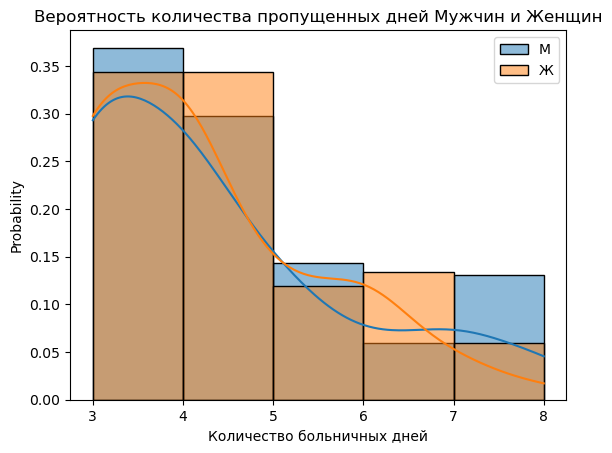

In [36]:
# Отобразим функцию плотности распределения для мужчин и женщин

ax = sns.histplot(men, label = 'М', stat='probability', kde=True, bins = np.arange(3, 9))
sns.histplot(women, label = 'Ж', stat='probability', kde=True, bins = np.arange(3, 9), ax = ax)
plt.title('Вероятность количества пропущенных дней Мужчин и Женщин')
plt.legend()
plt.show()

Мы не можем отбросить гипотезу $H_0$, тк в 33 случаях из 100 мы будем получать подобные или ещё более экстремальные значения

#### 2. Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег.

Пусть математическое ожидание работников старше 35 лет $\mu_1$, работников младше 35 лет - $\mu_2$, тогда
1. $H_0$: $\mu_1$ <= $\mu_2$
2. $H_1$: $\mu_1$ > $\mu_2$

In [29]:
old = df.loc[(df['Возрастная группа'] == 'Старше 35 лет') & (df['Количество больничных дней'] > 2), 'Количество больничных дней']
yng = df.loc[(df['Возрастная группа'] == 'Младше 35 лет') & (df['Количество больничных дней'] > 2), 'Количество больничных дней']

result = st.ttest_ind(old, yng, equal_var = False, alternative='greater')
pvalue = result.pvalue / 2
alpha = .05

print(f'p-value: {pvalue}')

if (pvalue < alpha):
    print('Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег.')
else:
    print('Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни также или реже своих более молодых коллег')

p-value: 0.38306045316680615
Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни также или реже своих более молодых коллег


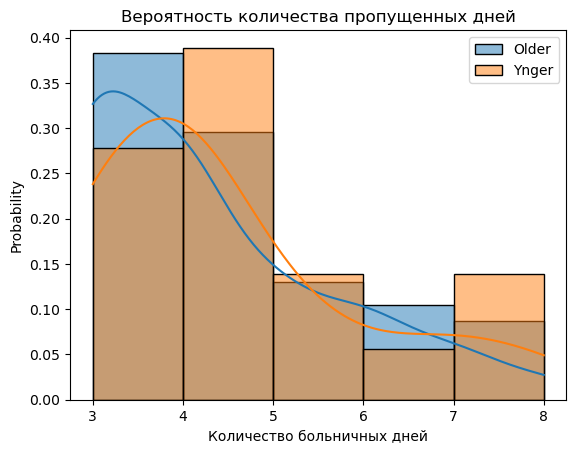

In [30]:
# Отобразим функцию плотности распределения для мужчин и женщин

ax = sns.histplot(old, label = 'Older', stat='probability', kde=True, bins = np.arange(3, 9))
sns.histplot(yng, label = 'Ynger', stat='probability', kde=True, bins = np.arange(3, 9), ax = ax)
plt.title('Вероятность количества пропущенных дней')
plt.legend()
plt.show()

Мы не можем отбросить гипотезу $H_0$, тк в 38 случаях из 100 мы будем получать подобные или ещё более экстремальные значения